# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.382623
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ Initially, the model should give probability of every class:1/10, and the loss then should be -log(0.1).



In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.800241 analytic: -0.800241, relative error: 3.204326e-08
numerical: -3.444316 analytic: -3.444316, relative error: 2.728683e-09
numerical: 0.628125 analytic: 0.628125, relative error: 9.080841e-08
numerical: 1.049605 analytic: 1.049605, relative error: 4.995045e-08
numerical: 0.776500 analytic: 0.776499, relative error: 3.431982e-08
numerical: -3.085022 analytic: -3.085022, relative error: 8.484812e-09
numerical: 0.287294 analytic: 0.287294, relative error: 3.506451e-08
numerical: -0.773910 analytic: -0.773910, relative error: 2.704443e-08
numerical: -0.762251 analytic: -0.762251, relative error: 3.708095e-08
numerical: -0.484336 analytic: -0.484336, relative error: 6.895626e-08
numerical: -0.237996 analytic: -0.237996, relative error: 4.699546e-08
numerical: -0.988821 analytic: -0.988821, relative error: 5.209239e-08
numerical: 0.043120 analytic: 0.043120, relative error: 2.500237e-07
numerical: 3.376907 analytic: 3.376907, relative error: 8.770958e-09
numerical: 3.41223

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.382623e+00 computed in 0.163252s
vectorized loss: 2.382623e+00 computed in 0.003105s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
rng = np.random.default_rng()
learning_rates = 10**(-1 * rng.random(10,) - 6) #[1e-7, 5e-5]
regularization_strengths = 10**(1 * rng.random(10,) + 4.0) #[2.5e4, 5e4]

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        #print('lr:',learning_rate,'; reg:', regularization_strength)
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength, num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        y_train_acc = np.mean(y_train_pred==y_train)
        y_val_acc = np.mean(y_val_pred==y_val)
        results[(learning_rate, regularization_strength)] = [y_train_acc, y_val_acc]
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 554.502860
iteration 100 / 1500: loss 3.936774
iteration 200 / 1500: loss 2.046264
iteration 300 / 1500: loss 2.126978
iteration 400 / 1500: loss 2.054485
iteration 500 / 1500: loss 2.086567
iteration 600 / 1500: loss 1.973379
iteration 700 / 1500: loss 2.013208
iteration 800 / 1500: loss 2.098555
iteration 900 / 1500: loss 2.104237
iteration 1000 / 1500: loss 2.004473
iteration 1100 / 1500: loss 2.121513
iteration 1200 / 1500: loss 2.049798
iteration 1300 / 1500: loss 1.966783
iteration 1400 / 1500: loss 2.059405
iteration 0 / 1500: loss 1501.377833
iteration 100 / 1500: loss 2.106840
iteration 200 / 1500: loss 2.189677
iteration 300 / 1500: loss 2.156026
iteration 400 / 1500: loss 2.131761
iteration 500 / 1500: loss 2.127666
iteration 600 / 1500: loss 2.170555
iteration 700 / 1500: loss 2.135382
iteration 800 / 1500: loss 2.182443
iteration 900 / 1500: loss 2.100178
iteration 1000 / 1500: loss 2.161338
iteration 1100 / 1500: loss 2.140426
iteration 1200 / 150

iteration 0 / 1500: loss 1025.293204
iteration 100 / 1500: loss 122.284818
iteration 200 / 1500: loss 16.230311
iteration 300 / 1500: loss 3.790117
iteration 400 / 1500: loss 2.329702
iteration 500 / 1500: loss 2.147787
iteration 600 / 1500: loss 2.128382
iteration 700 / 1500: loss 2.127278
iteration 800 / 1500: loss 2.145936
iteration 900 / 1500: loss 2.090574
iteration 1000 / 1500: loss 2.087247
iteration 1100 / 1500: loss 2.145995
iteration 1200 / 1500: loss 2.061621
iteration 1300 / 1500: loss 2.133938
iteration 1400 / 1500: loss 2.099996
iteration 0 / 1500: loss 232.700365
iteration 100 / 1500: loss 143.552689
iteration 200 / 1500: loss 89.225591
iteration 300 / 1500: loss 55.931488
iteration 400 / 1500: loss 35.375946
iteration 500 / 1500: loss 22.605433
iteration 600 / 1500: loss 14.791391
iteration 700 / 1500: loss 9.934226
iteration 800 / 1500: loss 6.830588
iteration 900 / 1500: loss 5.013594
iteration 1000 / 1500: loss 3.890940
iteration 1100 / 1500: loss 3.111506
iteration 

iteration 1400 / 1500: loss 2.045547
iteration 0 / 1500: loss 555.492273
iteration 100 / 1500: loss 158.956364
iteration 200 / 1500: loss 46.839215
iteration 300 / 1500: loss 14.767974
iteration 400 / 1500: loss 5.657640
iteration 500 / 1500: loss 3.108097
iteration 600 / 1500: loss 2.412721
iteration 700 / 1500: loss 2.117208
iteration 800 / 1500: loss 2.140308
iteration 900 / 1500: loss 2.087018
iteration 1000 / 1500: loss 2.071184
iteration 1100 / 1500: loss 2.052593
iteration 1200 / 1500: loss 2.085700
iteration 1300 / 1500: loss 2.149969
iteration 1400 / 1500: loss 2.049408
iteration 0 / 1500: loss 1499.051301
iteration 100 / 1500: loss 50.945459
iteration 200 / 1500: loss 3.758554
iteration 300 / 1500: loss 2.227938
iteration 400 / 1500: loss 2.149992
iteration 500 / 1500: loss 2.104145
iteration 600 / 1500: loss 2.133299
iteration 700 / 1500: loss 2.124542
iteration 800 / 1500: loss 2.132034
iteration 900 / 1500: loss 2.148156
iteration 1000 / 1500: loss 2.136328
iteration 1100 

iteration 1300 / 1500: loss 4.205977
iteration 1400 / 1500: loss 3.561574
iteration 0 / 1500: loss 1007.505217
iteration 100 / 1500: loss 164.178968
iteration 200 / 1500: loss 28.158207
iteration 300 / 1500: loss 6.315103
iteration 400 / 1500: loss 2.777971
iteration 500 / 1500: loss 2.183224
iteration 600 / 1500: loss 2.124511
iteration 700 / 1500: loss 2.128069
iteration 800 / 1500: loss 2.072084
iteration 900 / 1500: loss 2.103139
iteration 1000 / 1500: loss 2.142570
iteration 1100 / 1500: loss 2.095101
iteration 1200 / 1500: loss 2.064861
iteration 1300 / 1500: loss 2.133005
iteration 1400 / 1500: loss 2.164780
iteration 0 / 1500: loss 230.381348
iteration 100 / 1500: loss 152.436655
iteration 200 / 1500: loss 101.750493
iteration 300 / 1500: loss 68.058148
iteration 400 / 1500: loss 45.806052
iteration 500 / 1500: loss 31.044947
iteration 600 / 1500: loss 21.312110
iteration 700 / 1500: loss 14.883878
iteration 800 / 1500: loss 10.431954
iteration 900 / 1500: loss 7.623838
iterati

iteration 1200 / 1500: loss 2.048640
iteration 1300 / 1500: loss 2.081340
iteration 1400 / 1500: loss 1.913158
iteration 0 / 1500: loss 553.660669
iteration 100 / 1500: loss 53.609219
iteration 200 / 1500: loss 6.889049
iteration 300 / 1500: loss 2.533838
iteration 400 / 1500: loss 2.122044
iteration 500 / 1500: loss 2.065787
iteration 600 / 1500: loss 2.069138
iteration 700 / 1500: loss 2.075237
iteration 800 / 1500: loss 2.046982
iteration 900 / 1500: loss 2.064350
iteration 1000 / 1500: loss 2.095801
iteration 1100 / 1500: loss 2.125613
iteration 1200 / 1500: loss 2.071891
iteration 1300 / 1500: loss 2.050793
iteration 1400 / 1500: loss 2.045862
iteration 0 / 1500: loss 1512.618032
iteration 100 / 1500: loss 4.426686
iteration 200 / 1500: loss 2.124932
iteration 300 / 1500: loss 2.128677
iteration 400 / 1500: loss 2.120220
iteration 500 / 1500: loss 2.180040
iteration 600 / 1500: loss 2.120591
iteration 700 / 1500: loss 2.158870
iteration 800 / 1500: loss 2.088483
iteration 900 / 15

iteration 1100 / 1500: loss 7.538877
iteration 1200 / 1500: loss 5.945879
iteration 1300 / 1500: loss 4.824656
iteration 1400 / 1500: loss 4.039694
iteration 0 / 1500: loss 1011.285587
iteration 100 / 1500: loss 184.876557
iteration 200 / 1500: loss 35.273696
iteration 300 / 1500: loss 8.109782
iteration 400 / 1500: loss 3.160752
iteration 500 / 1500: loss 2.279803
iteration 600 / 1500: loss 2.162677
iteration 700 / 1500: loss 2.145790
iteration 800 / 1500: loss 2.079983
iteration 900 / 1500: loss 2.122629
iteration 1000 / 1500: loss 2.095565
iteration 1100 / 1500: loss 2.111645
iteration 1200 / 1500: loss 2.113471
iteration 1300 / 1500: loss 2.123054
iteration 1400 / 1500: loss 2.089129
iteration 0 / 1500: loss 230.879752
iteration 100 / 1500: loss 156.487188
iteration 200 / 1500: loss 107.111858
iteration 300 / 1500: loss 73.417665
iteration 400 / 1500: loss 50.575652
iteration 500 / 1500: loss 35.112175
iteration 600 / 1500: loss 24.540807
iteration 700 / 1500: loss 17.335836
iterat

iteration 900 / 1500: loss 5.811017
iteration 1000 / 1500: loss 4.316980
iteration 1100 / 1500: loss 3.384606
iteration 1200 / 1500: loss 2.813992
iteration 1300 / 1500: loss 2.515863
iteration 1400 / 1500: loss 2.321453
iteration 0 / 1500: loss 554.058465
iteration 100 / 1500: loss 9.143054
iteration 200 / 1500: loss 2.111841
iteration 300 / 1500: loss 2.014030
iteration 400 / 1500: loss 2.041840
iteration 500 / 1500: loss 2.079215
iteration 600 / 1500: loss 2.037501
iteration 700 / 1500: loss 2.055130
iteration 800 / 1500: loss 2.097940
iteration 900 / 1500: loss 2.131725
iteration 1000 / 1500: loss 2.009609
iteration 1100 / 1500: loss 2.050866
iteration 1200 / 1500: loss 2.035469
iteration 1300 / 1500: loss 2.027712
iteration 1400 / 1500: loss 2.099015
iteration 0 / 1500: loss 1497.899569
iteration 100 / 1500: loss 2.161136
iteration 200 / 1500: loss 2.183655
iteration 300 / 1500: loss 2.189580
iteration 400 / 1500: loss 2.118906
iteration 500 / 1500: loss 2.167166
iteration 600 / 1

In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.379000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True.


$\color{blue}{\textit Your Explanation:}$ When the new datapoint is delicately chosen so that every new segment of SVM loss is 0, the SVM loss is unchanged. However, the Softmax classifier loss always increase with new datapoints according to the loss function formula.



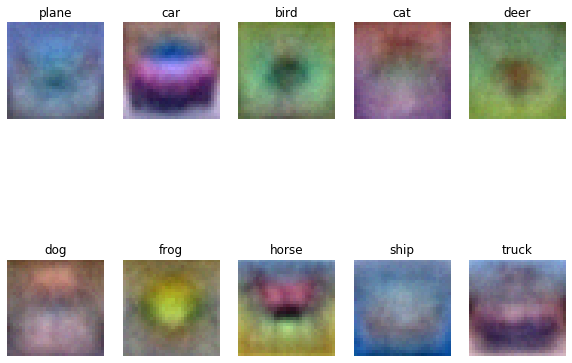

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])